IE 6400 Project 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting working directory
%cd /content/drive/MyDrive/Project2/

/content/drive/MyDrive/Project2


In [ ]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)


In [ ]:

ACC = pd.read_csv('accelerometer_data.csv')


In [ ]:
ACC.head(10)


In [ ]:
ACC['timestamp'] = (ACC['time'])//1000
ACC.drop(columns=['time'], inplace=True)
ACC

,pid,x,y,z,timestamp
0,JB3156,0.000000,0.000000,0.000000,0
1,CC6740,0.000000,0.000000,0.000000,0
2,SA0297,0.075800,0.027300,-0.010200,1493733882
3,SA0297,-0.035900,0.079400,0.003700,1493733882
4,SA0297,-0.242700,-0.086100,-0.016300,1493733882
...,...,...,...,...,...
14057562,CC6740,-0.133956,0.124726,-0.010736,1493829248
14057563,CC6740,-0.100764,0.180872,0.046449,1493829248
14057564,CC6740,-0.131853,0.195934,0.181088,1493829248
14057565,CC6740,-0.149704,0.194482,0.202393,1493829248


In [ ]:
#now working with TAC data below

In [ ]:
#########test merging########
%cd /content/drive/MyDrive/Project2/CleanTAC
BKdf = pd.read_csv('BK7610_clean_TAC.csv')
BKdf['pid'] = 'BK7610'
BKdf.head(10)

/content/drive/MyDrive/Project2/CleanTAC


,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610
5,1493722016,-0.002159,BK7610
6,1493722345,-0.001033,BK7610
7,1493722674,0.001808,BK7610
8,1493723003,0.004542,BK7610
9,1493724832,0.005185,BK7610


In [ ]:
JBdf = pd.read_csv('JB3156_clean_TAC.csv')
JBdf.head(10)

,timestamp,TAC_Reading
0,1493722816,0.002387
1,1493724639,0.000271
2,1493724954,-0.000839
3,1493725268,-0.000651
4,1493725583,0.000234
5,1493725897,0.000813
6,1493726211,0.000479
7,1493726526,-0.000503
8,1493726840,-0.001214
9,1493727172,-0.000858


In [ ]:
#Testing a join of the two previous tables before I merge the rest in
merged = pd.concat([BKdf, JBdf], axis=0)
merged
#########end of test############

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610
...,...,...,...
50,1493799481,0.000115,NaN
51,1493801311,-0.000309,NaN
52,1493803140,-0.000136,NaN
53,1493804971,0.000097,NaN


In [ ]:
#Gathering the rest of the Clean TAC recordings in directory
folder_path = '/content/drive/MyDrive/Project2/CleanTAC'
CleanTAC = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
CleanTAC

['DK3500_clean_TAC.csv',
 'SA0297_clean_TAC.csv',
 'JB3156_clean_TAC.csv',
 'CC6740_clean_TAC.csv',
 'DC6359_clean_TAC.csv',
 'SF3079_clean_TAC.csv',
 'HV0618_clean_TAC.csv',
 'BU4707_clean_TAC.csv',
 'MC7070_clean_TAC.csv',
 'BK7610_clean_TAC.csv',
 'MJ8002_clean_TAC.csv',
 'PC6771_clean_TAC.csv',
 'JR8022_clean_TAC.csv']

In [ ]:
#Shortening the headers to the first 6 Characters in each csv file
headers = [csv[0:6] for csv in CleanTAC]
headers

['DK3500',
 'SA0297',
 'JB3156',
 'CC6740',
 'DC6359',
 'SF3079',
 'HV0618',
 'BU4707',
 'MC7070',
 'BK7610',
 'MJ8002',
 'PC6771',
 'JR8022']

In [ ]:
#putting the names of each phone type used into a separate column of pid for this array of dfs#####
TACdfs = []
for csv, CleanTAC in enumerate(CleanTAC):
    dfr = pd.read_csv(os.path.join(folder_path, CleanTAC))
    dfr['pid'] = headers[csv]
    TACdfs.append(dfr)

TACdfs

In [ ]:
#concatenating
TAC = pd.concat(TACdfs, ignore_index=True)

TAC
#The above is a dataframe that shows all of the Phone IDs listed with their TAC readings together

,timestamp,TAC_Reading,pid
0,1493727820,0.000215,DK3500
1,1493728019,0.001716,DK3500
2,1493729841,0.001921,DK3500
3,1493731667,0.000569,DK3500
4,1493731994,-0.001321,DK3500
...,...,...,...
710,1493796643,0.012688,JR8022
711,1493798466,0.010780,JR8022
712,1493800288,0.008092,JR8022
713,1493802111,0.005726,JR8022


In [ ]:
#And for later use I will create a dataframe without the pid column
TAC_no_pid = TAC.drop(columns=['pid'])

TAC_no_pid

,timestamp,TAC_Reading
0,1493727820,0.000215
1,1493728019,0.001716
2,1493729841,0.001921
3,1493731667,0.000569
4,1493731994,-0.001321
...,...,...
710,1493796643,0.012688
711,1493798466,0.010780
712,1493800288,0.008092
713,1493802111,0.005726


In [ ]:
#organizing the table in increasing order of the 'timestamp' column
TAC.sort_values('timestamp')
TAC

,timestamp,TAC_Reading,pid
0,1493727820,0.000215,DK3500
1,1493728019,0.001716,DK3500
2,1493729841,0.001921,DK3500
3,1493731667,0.000569,DK3500
4,1493731994,-0.001321,DK3500
...,...,...,...
710,1493796643,0.012688,JR8022
711,1493798466,0.010780,JR8022
712,1493800288,0.008092,JR8022
713,1493802111,0.005726,JR8022


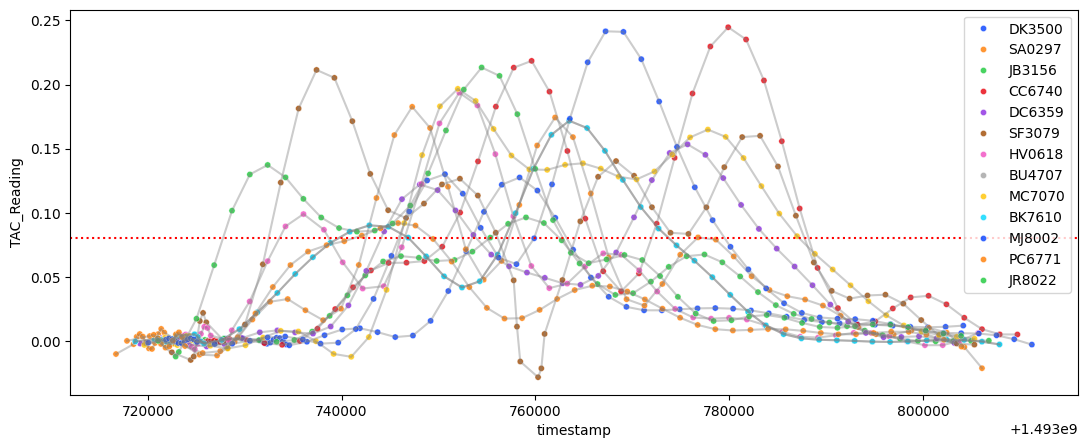

In [ ]:
plt.figure(figsize=(13, 5))
sns.scatterplot(data=TAC, x='timestamp', y='TAC_Reading', hue='pid', s=20, alpha=0.8, palette='bright')
#connecting same colored dots with a line
for category, data in TAC.groupby('pid'):
  #SAVE FOR LATER color = scatter.get_legend().get_texts()[list(_df_2['pid'].unique()).index(category)].get_color()
    sns.lineplot(data=data, x='timestamp', y='TAC_Reading', color='grey', alpha=.4)
#showing that .08 is the legal threshhold for intoxication
plt.axhline(y=0.08, color='red', linestyle=':')
plt.show()

**I created the above plot to visualize how in each of the phone's TAC recording,
the level of alcohol fluctuates over time. Every person recorded starts and ends below the legal limit of alcohol (.08 shown with red line). However, at certain points they are far above.**

In [ ]:
#merging TAC data with Accelerometer data
total_df = pd.merge(ACC, TAC_no_pid, on = ['timestamp'])

total_df

**While I initially explored a way to merge all of the accelerometer data to the combined TAC dataframe with all of the pids shown together, it will make more sense moving forward to explore each pid's data idependently to determine whether permutation entropy and complexity method is reliable in
differentiating heavy drinking vs. sober cases**

MOVING FORWARD to explore individual cases,
I have listed the most relevant data frames created this far for my own convenience below:


*   TAC        - all of the phones' combined TAC readings ordered by timestamp | (715 rows × 3 columns)
*   TAC_no_pid - TAC readings of all phones but not showing which pid they're from (715 rows × 2 columns)
*   ACC        - accelerometer data with x,y,z readings on all phones | (14057567 rows × 5 columns)
*   total_df   - The merged dfs of ACC and TAC_no_pid (82592 rows × 6 columns)





In [ ]:

print(list(total_df.columns))


['pid', 'x', 'y', 'z', 'timestamp', 'TAC_Reading']


In [ ]:
#Creating a dataframe of accelerometer readings and TAC readings using just pid BK7610
BK7610 = total_df[total_df['pid'].str.contains('BK7610')]

BK7610

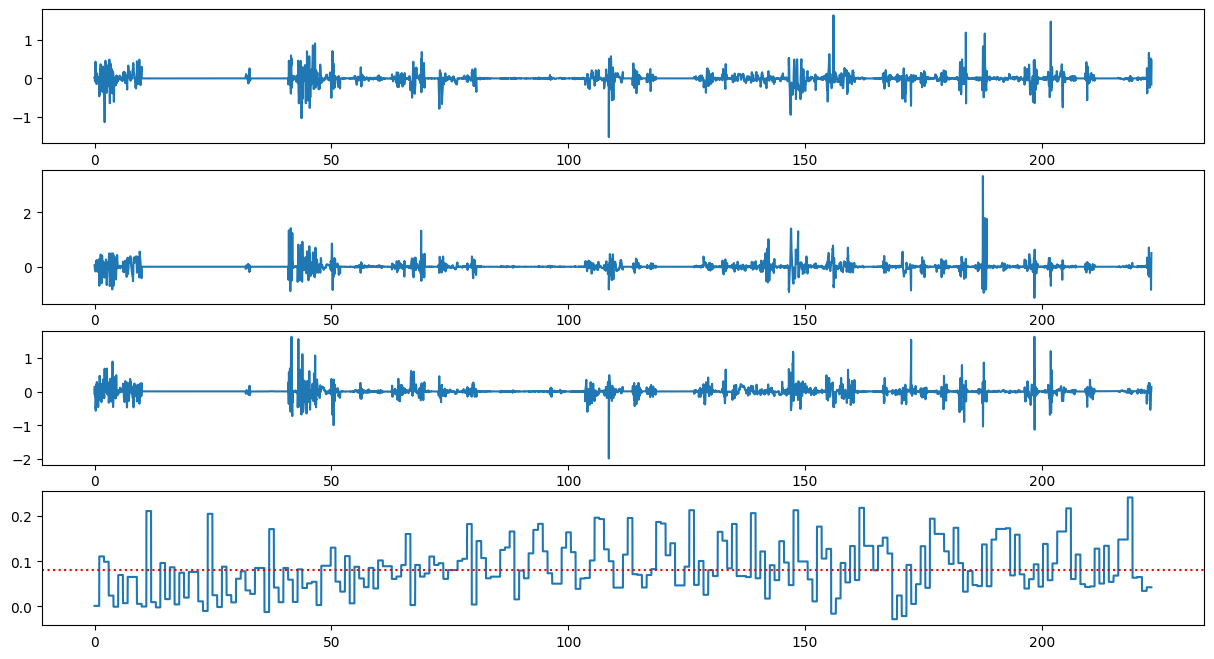

In [ ]:

fig, ax = plt.subplots(4,figsize=(15,8))
#showing time as divided by 40 since the accelerometer data was measured as 40Hz
time = np.arange(BK7610['x'].size)/40

ax[0].plot(time, BK7610['x'])
ax[1].plot(time, BK7610['y'])
ax[2].plot(time, BK7610['z'])
ax[3].plot(time, BK7610['TAC_Reading'])

ax[3].axhline(y=.08, color='r', linestyle=':')

I did this initially only to realize that my TAC readings were fluctuating too much in comparison to the first plot I made of all combined pids of TAC data shown below. 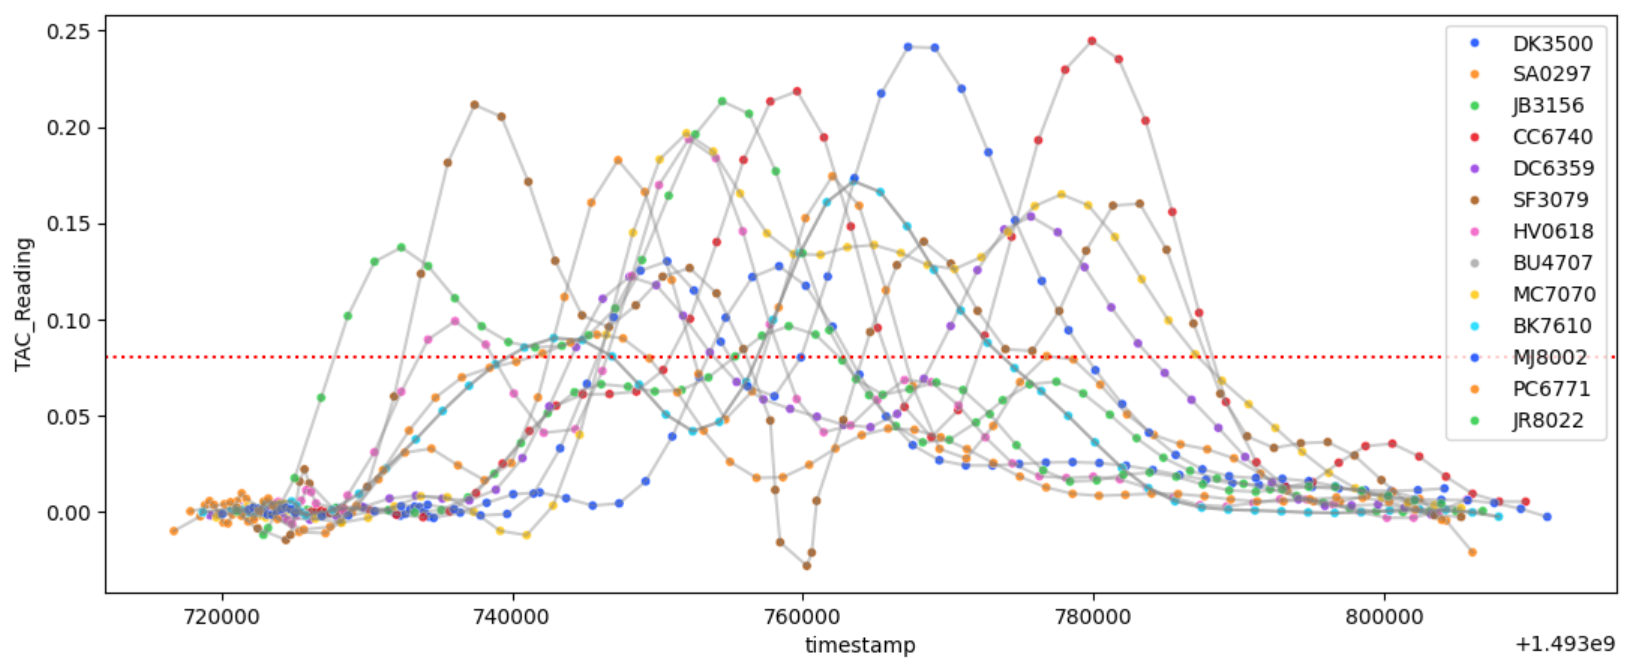

So, after consulting with some other students, I realized that I have to merge each of the pid TAC dataframes into the ACC dataframe for better results. Through these discusions, I discovered that this gives less variation in TAC readings from any given pid.

In [88]:
#defining a function for multiple subplots
def plot4(df):

  fig, ax = plt.subplots(4,figsize=(15,8))
  #showing time as divided by 40 since the accelerometer data was measured as 40Hz
  time = np.arange(df['x'].size)/40

  ax[0].plot(time, df['x'])
  ax[1].plot(time, df['y'])
  ax[2].plot(time, df['z'])
  ax[3].plot(time, df['TAC_Reading'])

  ax[3].axhline(y=.08, color='r', linestyle=':')

In [87]:
SA0297 = pd.read_csv('SA0297_clean_TAC.csv')

#merging TAC data with Accelerometer data
total_df = pd.merge(ACC, SA0297, on = ['timestamp'])

SA0297 = total_df[total_df['pid']=='SA0297']
SA0297

,pid,x,y,z,timestamp,TAC_Reading
0,SA0297,0.1312,0.0432,0.0034,1493734448,0.032672
1,SA0297,0.2734,0.1197,0.0968,1493734448,0.032672
2,SA0297,0.1514,0.1886,0.0375,1493734448,0.032672
3,SA0297,-0.0914,0.0496,0.0534,1493734448,0.032672
4,SA0297,-0.7935,-0.5184,0.3967,1493734448,0.032672
...,...,...,...,...,...,...
6260,SA0297,-0.0012,0.0006,-0.0058,1493806094,-0.021275
6269,SA0297,-0.0025,-0.0006,-0.0056,1493806094,-0.021275
6278,SA0297,-0.0012,0.0002,-0.0043,1493806094,-0.021275
6283,SA0297,-0.0012,-0.0007,-0.0040,1493806094,-0.021275


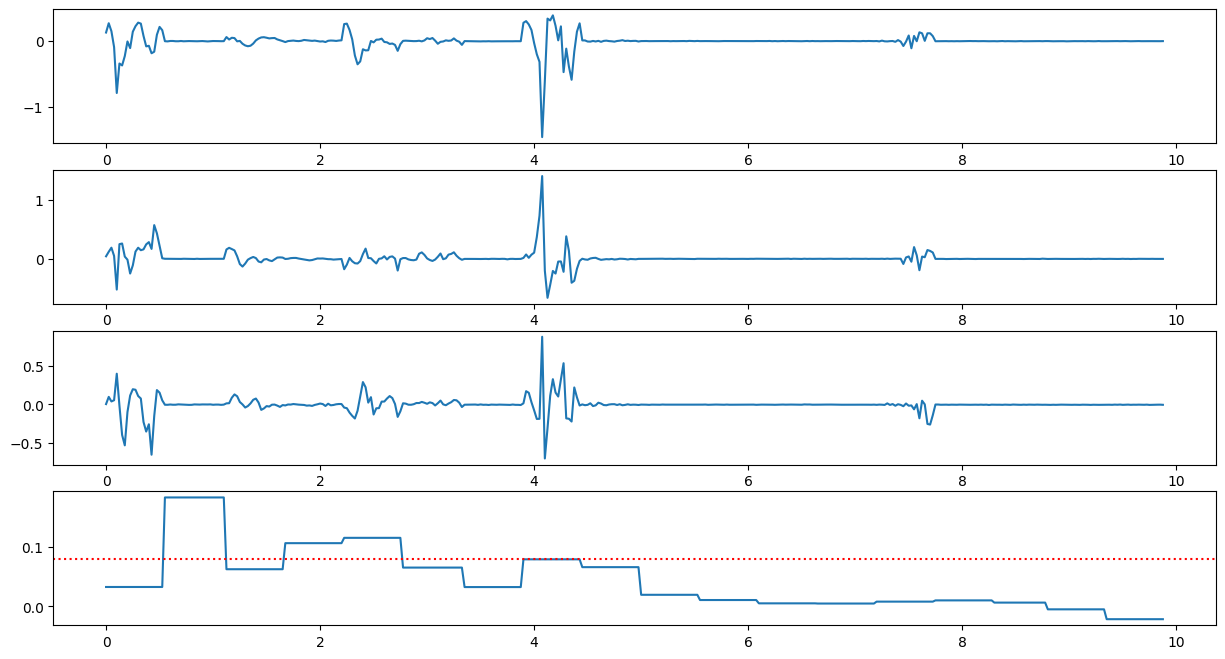

In [89]:
plot4(SA0297)

This looks much better with less sporadic TAC readings.

Now, I will look at a different phone ID, pid = DC6359

In [ ]:
DC6359 = pd.read_csv('DC6359_clean_TAC.csv')

#merging TAC data with Accelerometer data
total_df = pd.merge(ACC, DC6359, on = ['timestamp'])

DC6359 = total_df[total_df['pid']=='DC6359']
DC6359

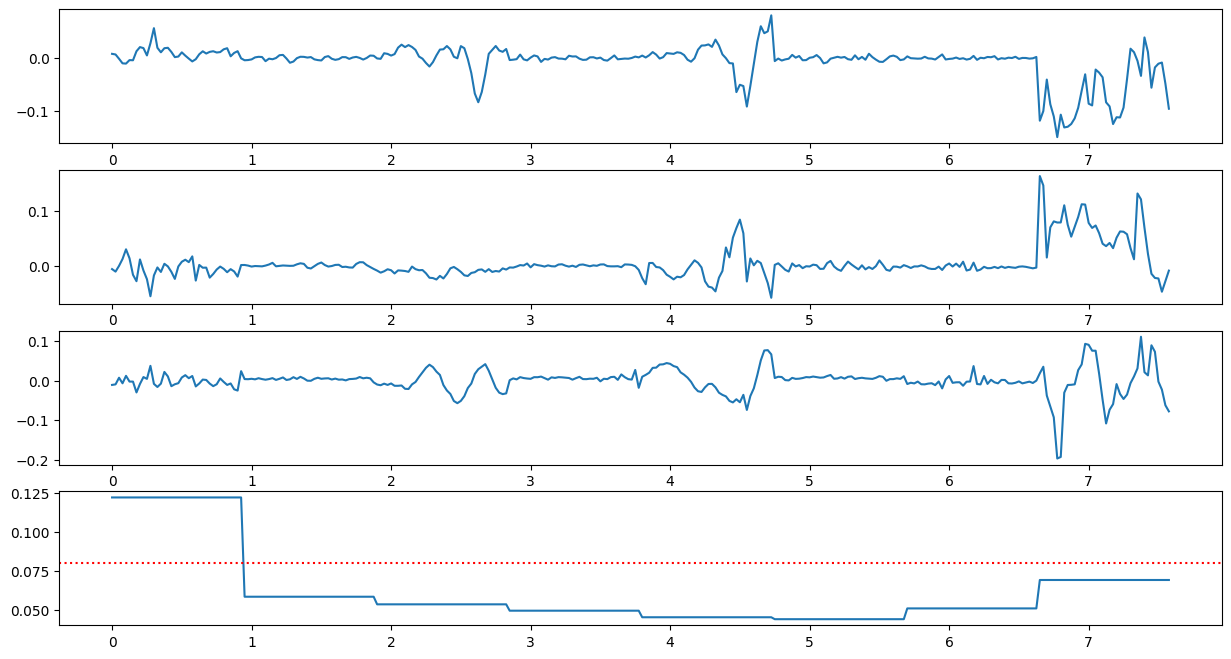

In [93]:
plot4(DC6359)

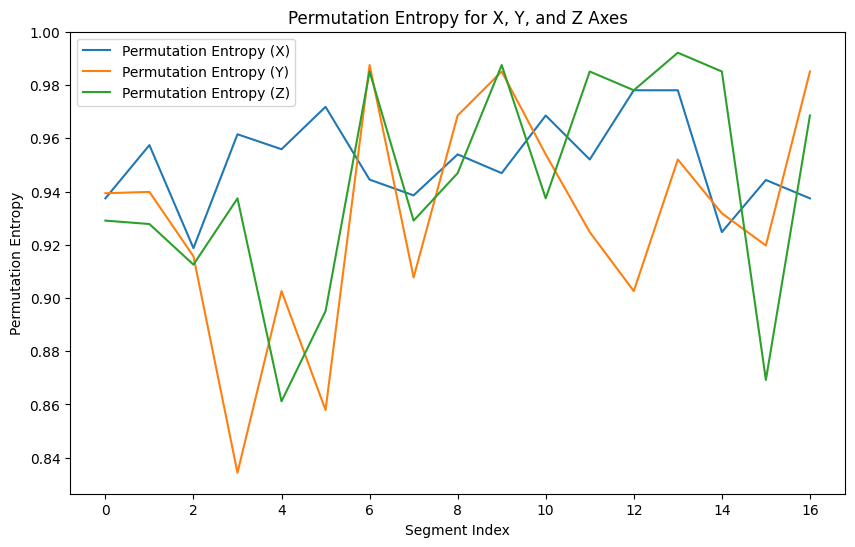

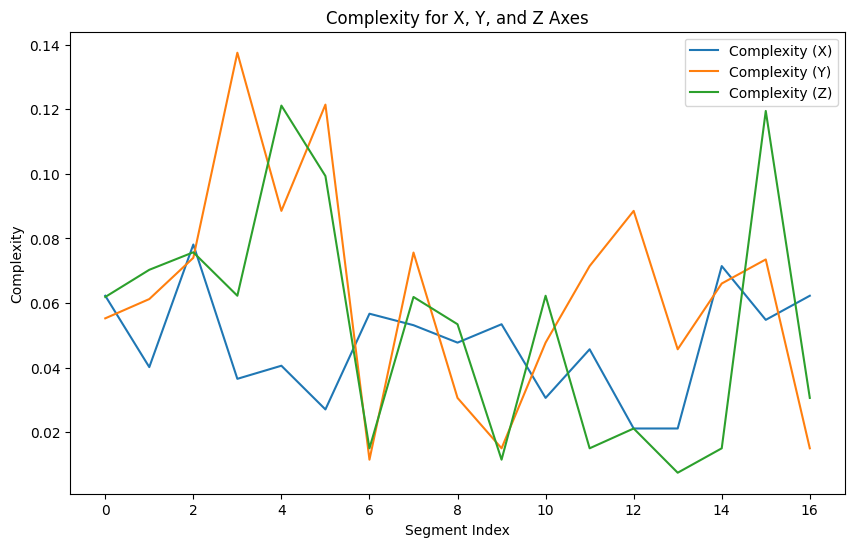

In [97]:
import math

def s_entropy(freq_list):
    ''' This function computes the Shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing Shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return sh_entropy

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 preferred range), embdelay = embedding delay
    OUTPUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = np.array(ts)
    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * math.factorial(n-1) + _hash(x[:, 1:])

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return s_entropy(p) / max_entropy

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entropy
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5 + ((1 - 0.5) / len(op))) * np.log(0.5 + ((1 - 0.5) / len(op)))
    constant2 = ((1 - 0.5) / len(op)) * np.log((1 - 0.5) / len(op)) * (len(op) - 1)
    constant3 = 0.5 * np.log(len(op))
    Q_o = -1 / (constant1 + constant2 + constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5 * temp_op_prob) + (0.5 * (1 / len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return Comp_JS

# Define a function to calculate permutation entropy and complexity
def calculate_entropy_and_complexity(df_segment, axis):
    op = ordinal_patterns(df_segment[axis], 3, 1)  # Assuming 'ordinal_patterns' function is defined
    pe = p_entropy(op)  # Assuming 'p_entropy' function is defined
    comp = complexity(op)  # Assuming 'complexity' function is defined
    return pe, comp



#########################################################################################################
# Define the segment start and end indices based on changes in timestamp
#USING PID FROM SA0297
segment_start_indices = [0]
for i in range(1, len(SA0297)):
    if SA0297['TAC_Reading'].iloc[i] != SA0297['TAC_Reading'].iloc[i-1]:
        segment_start_indices.append(i)

# Calculate entropy and complexity for each segment and axis
pe_results_x, pe_results_y, pe_results_z = [], [], []
comp_results_x, comp_results_y, comp_results_z = [], [], []
for i in range(1, len(segment_start_indices)):
    segment_start_index = segment_start_indices[i-1]
    segment_end_index = segment_start_indices[i]
    df_segment = SA0297.iloc[segment_start_index:segment_end_index]

    # Calculate entropy and complexity for each axis
    pe_x, comp_x = calculate_entropy_and_complexity(df_segment, 'x')
    pe_y, comp_y = calculate_entropy_and_complexity(df_segment, 'y')
    pe_z, comp_z = calculate_entropy_and_complexity(df_segment, 'z')

    # Append results to respective lists
    pe_results_x.append(pe_x)
    pe_results_y.append(pe_y)
    pe_results_z.append(pe_z)
    comp_results_x.append(comp_x)
    comp_results_y.append(comp_y)
    comp_results_z.append(comp_z)

# Plot permutation entropy results for each axis
plt.figure(figsize=(10, 6))
sns.lineplot(data=pe_results_x, label='Permutation Entropy (X)')
sns.lineplot(data=pe_results_y, label='Permutation Entropy (Y)')
sns.lineplot(data=pe_results_z, label='Permutation Entropy (Z)')
plt.xlabel('Segment Index')
plt.ylabel('Permutation Entropy')
plt.title('Permutation Entropy for X, Y, and Z Axes')
plt.legend()
plt.show()

# Plot complexity results for each axis
plt.figure(figsize=(10, 6))
sns.lineplot(data=comp_results_x, label='Complexity (X)')
sns.lineplot(data=comp_results_y, label='Complexity (Y)')
sns.lineplot(data=comp_results_z, label='Complexity (Z)')
plt.xlabel('Segment Index')
plt.ylabel('Complexity')
plt.title('Complexity for X, Y, and Z Axes')
plt.legend()
plt.show()

**Start of another example for DC6359

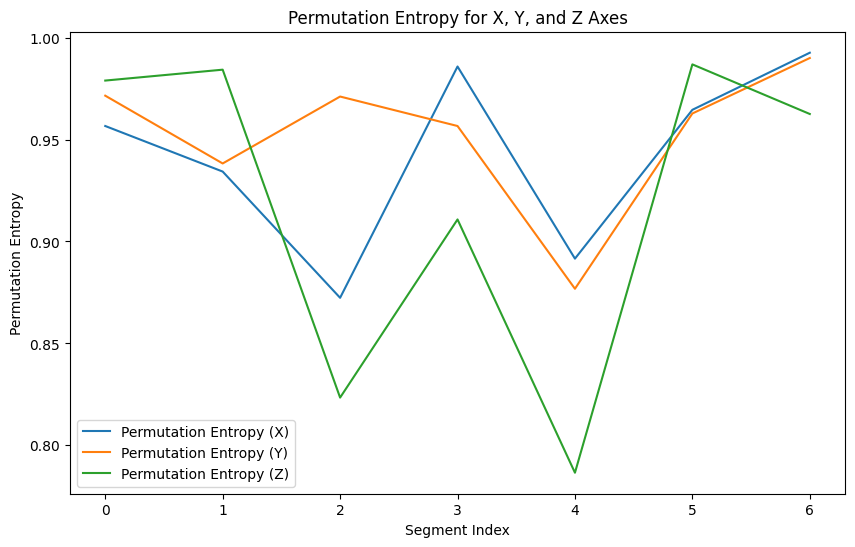

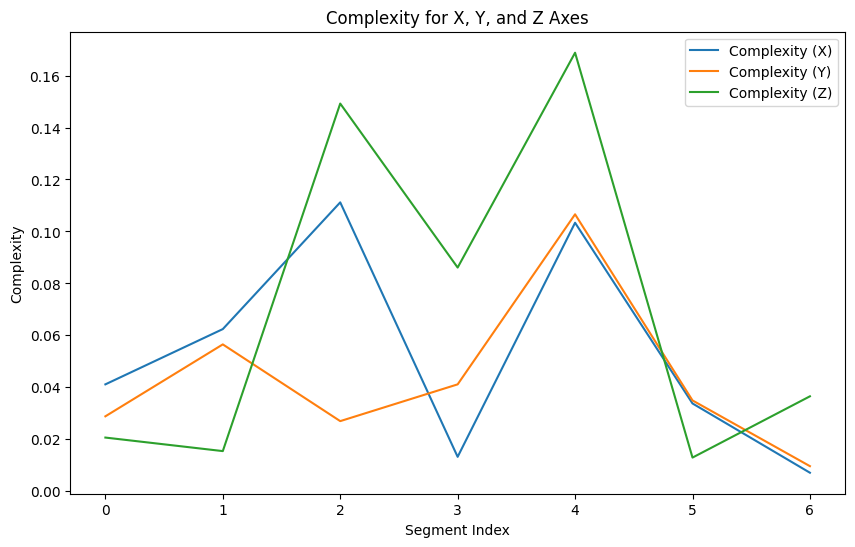

In [99]:
# Define the segment start and end indices based on changes in timestamp
segment_start_indices = [0]
for i in range(1, len(DC6359)):
    if DC6359['TAC_Reading'].iloc[i] != DC6359['TAC_Reading'].iloc[i-1]:
        segment_start_indices.append(i)

# Calculate entropy and complexity for each segment and axis
pe_results_x, pe_results_y, pe_results_z = [], [], []
comp_results_x, comp_results_y, comp_results_z = [], [], []
for i in range(1, len(segment_start_indices)):
    segment_start_index = segment_start_indices[i-1]
    segment_end_index = segment_start_indices[i]
    df_segment = DC6359.iloc[segment_start_index:segment_end_index]

    # Calculate entropy and complexity for each axis
    pe_x, comp_x = calculate_entropy_and_complexity(df_segment, 'x')
    pe_y, comp_y = calculate_entropy_and_complexity(df_segment, 'y')
    pe_z, comp_z = calculate_entropy_and_complexity(df_segment, 'z')

    # Append results to respective lists
    pe_results_x.append(pe_x)
    pe_results_y.append(pe_y)
    pe_results_z.append(pe_z)
    comp_results_x.append(comp_x)
    comp_results_y.append(comp_y)
    comp_results_z.append(comp_z)

# Plot permutation entropy results for each axis
plt.figure(figsize=(10, 6))
sns.lineplot(data=pe_results_x, label='Permutation Entropy (X)')
sns.lineplot(data=pe_results_y, label='Permutation Entropy (Y)')
sns.lineplot(data=pe_results_z, label='Permutation Entropy (Z)')
plt.xlabel('Segment Index')
plt.ylabel('Permutation Entropy')
plt.title('Permutation Entropy for X, Y, and Z Axes')
plt.legend()
plt.show()

# Plot complexity results for each axis
plt.figure(figsize=(10, 6))
sns.lineplot(data=comp_results_x, label='Complexity (X)')
sns.lineplot(data=comp_results_y, label='Complexity (Y)')
sns.lineplot(data=comp_results_z, label='Complexity (Z)')
plt.xlabel('Segment Index')
plt.ylabel('Complexity')
plt.title('Complexity for X, Y, and Z Axes')
plt.legend()
plt.show()

# Commentary
After running two different pid recordings of TAC over the time of the study and examining the permutation entropy and complexity in the above graphs it becomes apparent that both of these recordings have high values of entropy and complexity, especially with entropy. This leads me to believe the complexity method would be marginally more successful in differentiating heavy drinking vs. sober cases. Although, I would consider other methods combined to make the differentiation more reliable such as reviewing for autocorrelation or extracting frequency-domain features that may be indicative of heavy drinking behavior.

In [ ]:
######################################### END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ################################################################################################################################# END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ################################################################################################################################# END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ################################################################################################################################# END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ################################################################################################################################# END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ################################################################################################################################# END OF PROJECT 2 ########################################################################################
######################################### END OF PROJECT 2 ########################################################################################

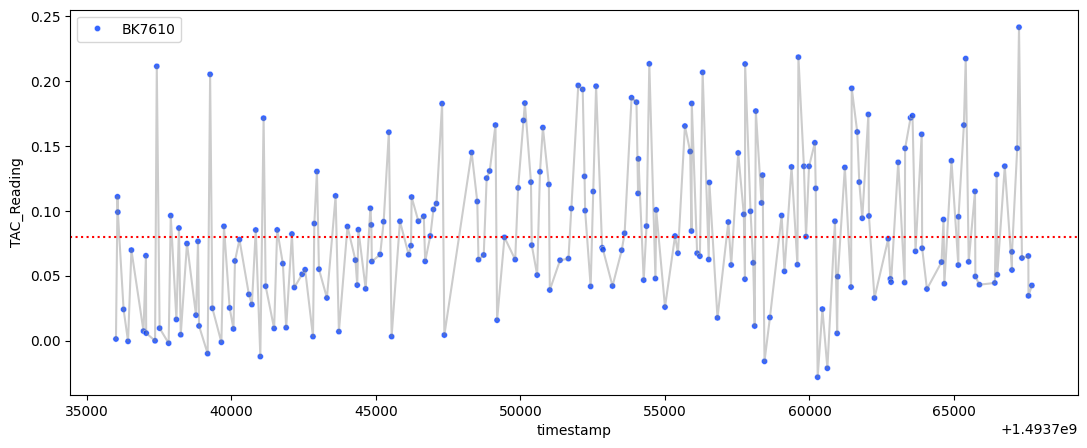

In [ ]:
plt.figure(figsize=(13, 5))
sns.scatterplot(data=BK7610, x='timestamp', y='TAC_Reading', hue='pid', s=20, alpha=0.8, palette='bright')
#connecting same colored dots with a line
for category, data in BK7610.groupby('pid'):
  #SAVE FOR LATER color = scatter.get_legend().get_texts()[list(_df_2['pid'].unique()).index(category)].get_color()
    sns.lineplot(data=BK7610, x='timestamp', y='TAC_Reading', color='grey', alpha=.4)
#showing that .08 is the legal threshhold for intoxication
plt.axhline(y=0.08, color='red', linestyle=':')
plt.show()

Investigate whether permutation entropy and complexity method is reliable in
differentiating heavy drinking vs. sober cases